Training the agents...


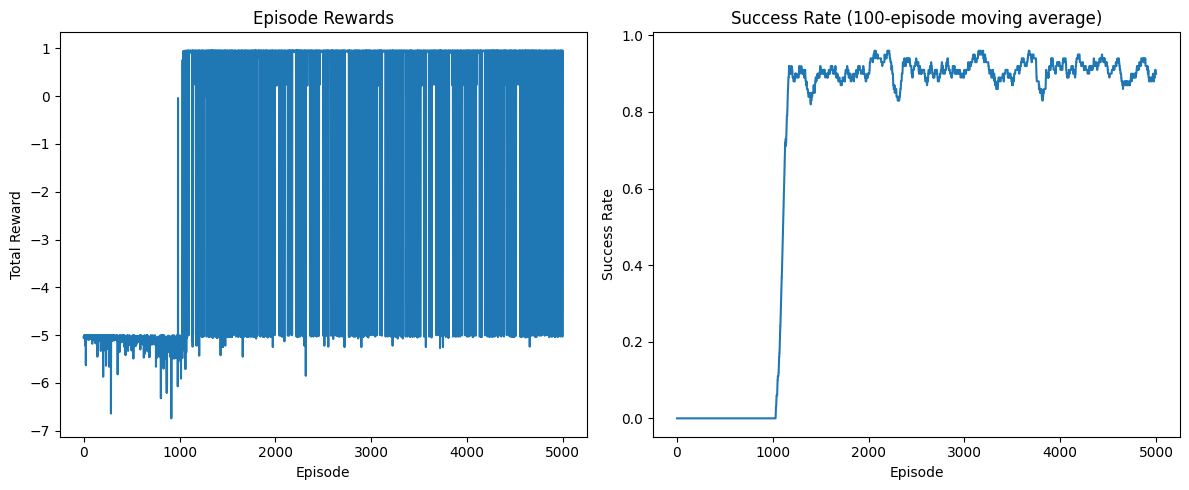

Training complete!
Comparing trained policy with random policy...
Trained Policy - Average Reward: 0.9500, Success Rate: 100.00%
Random Policy  - Average Reward: -5.0351, Success Rate: 0.00%
Visualizing the learned policy...

=== Test Episode 1 ===


2025-03-10 15:56:59.221 Python[33788:2043689] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/17/t6f3z0rd44jc522cqy2b5jzw0000gn/T/com.apple.python3.savedState


Step 1:
Agent 1: RIGHT, Agent 2: DOWN
Reward: -0.01
Step 2:
Agent 1: RIGHT, Agent 2: DOWN
Reward: -0.01
Step 3:
Agent 1: DOWN, Agent 2: UP
Reward: -0.01
Step 4:
Agent 1: DOWN, Agent 2: DOWN
Reward: -0.01
Step 5:
Agent 1: DOWN, Agent 2: DOWN
Reward: -0.01
/!\ Collision detected! Both agents are on the same tile. /!\ 
Step 6:
Agent 1: RIGHT, Agent 2: RIGHT
Reward: 1.0
/!\ Collision detected! Both agents are on the same tile. /!\ 
Episode finished after 6 steps with total reward: 0.95
Success! At least one agent reached the goal.

=== Test Episode 2 ===
Step 1:
Agent 1: RIGHT, Agent 2: DOWN
Reward: -0.01
Step 2:
Agent 1: RIGHT, Agent 2: DOWN
Reward: -0.01
Step 3:
Agent 1: DOWN, Agent 2: UP
Reward: -0.01
Step 4:
Agent 1: DOWN, Agent 2: DOWN
Reward: -0.01
Step 5:
Agent 1: DOWN, Agent 2: DOWN
Reward: -0.01
/!\ Collision detected! Both agents are on the same tile. /!\ 


2025-03-10 15:57:05.756 Python[33788:2043689] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Step 6:
Agent 1: RIGHT, Agent 2: RIGHT
Reward: 1.0
/!\ Collision detected! Both agents are on the same tile. /!\ 
Episode finished after 6 steps with total reward: 0.95
Success! At least one agent reached the goal.


: 

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time
import random
import sys
import pygame
from collections import defaultdict

# Define maps (since we can't directly access them from gymnasium now)
MAPS = {
    "4x4": [
        "SFFF",
        "FHSH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "SHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}

class MultiAgentFrozenLake(gym.Env):
    def __init__(self, map_name="4x4", max_steps=100):
        # Load the map
        self.desc = np.asarray(MAPS[map_name], dtype='c')
        self.nrow, self.ncol = self.desc.shape
        self.original_desc = self.desc.copy()  # Keep original for reference
        
        # Define action and observation spaces
        self.action_space = spaces.Tuple((spaces.Discrete(4), spaces.Discrete(4)))  # Actions for both agents
        
        # State space: (agent1_row, agent1_col, agent2_row, agent2_col)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.nrow), 
            spaces.Discrete(self.ncol),
            spaces.Discrete(self.nrow), 
            spaces.Discrete(self.ncol)
        ))
        
        self.max_steps = max_steps
        self.np_random = np.random.RandomState()
        self.reset()
        
    def reset(self, seed=None):
        if seed is not None:
            self.np_random = np.random.RandomState(seed)
        
        self.desc = self.original_desc.copy()
        start_positions = np.argwhere(self.desc == b'S')
        goal_position = np.argwhere(self.desc == b'G')[0]
        
        if len(start_positions) > 1:
            self.agent1_pos = start_positions[0]
            self.agent2_pos = start_positions[1]
        else:
            self.agent1_pos = start_positions[0]
            self.agent2_pos = start_positions[0].copy()
        
        self.goal_pos = goal_position
        self.steps = 0
        self.agents_goal_steps = [None, None]
        
        self.state = (self.agent1_pos[0], self.agent1_pos[1], self.agent2_pos[0], self.agent2_pos[1])
        return self.state, {}
    

    def step(self, actions):
        self.steps += 1
        action1, action2 = actions
        
        if self.steps == 1:
            start_positions = np.argwhere(self.desc == b'S')
            for pos in start_positions:
                self.desc[pos[0], pos[1]] = b'F'
        
        self.agent1_pos = self._move_agent(self.agent1_pos, action1)
        self.agent2_pos = self._move_agent(self.agent2_pos, action2)
        
        done1 = np.array_equal(self.agent1_pos, self.goal_pos)
        done2 = np.array_equal(self.agent2_pos, self.goal_pos)
        
        if done1 and self.agents_goal_steps[0] is None:
            self.agents_goal_steps[0] = self.steps
        if done2 and self.agents_goal_steps[1] is None:
            self.agents_goal_steps[1] = self.steps
        
        self.state = (self.agent1_pos[0], self.agent1_pos[1], self.agent2_pos[0], self.agent2_pos[1])
        done = (done1 and done2) or self.steps >= self.max_steps
        
        agent1_fallen = self.desc[self.agent1_pos[0], self.agent1_pos[1]] == b'H'
        agent2_fallen = self.desc[self.agent2_pos[0], self.agent2_pos[1]] == b'H'
        
        if agent1_fallen or agent2_fallen:
            reward = -5.0  # Immediate failure if any agent falls
            done = True
        elif done1 and done2:
            if self.agents_goal_steps[0] == self.agents_goal_steps[1]:
                reward = 1.0  # Full reward if they arrive together
            else:
                reward = 0.5  # Partial reward if they arrive at different times
            done = True
        elif done1 or done2:
            reward = -0.2  # Penalize reaching the goal alone
        else:
            reward = -0.01  # Small penalty to encourage movement

        truncated = self.steps >= self.max_steps
        return self.state, reward, done, truncated, {}
    
    def _move_agent(self, position, action):
        # Get new position
        new_position = position.copy()
        
        # 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP
        if action == 0:  # LEFT
            new_position[1] = max(0, position[1] - 1)
        elif action == 1:  # DOWN
            new_position[0] = min(self.nrow - 1, position[0] + 1)
        elif action == 2:  # RIGHT
            new_position[1] = min(self.ncol - 1, position[1] + 1)
        elif action == 3:  # UP
            new_position[0] = max(0, position[0] - 1)
        
        # Check if new position is a hole or valid
        if self.desc[new_position[0], new_position[1]] != b'H':
            return new_position
        else:
            # If it's a hole, agent falls in
            return new_position

    def render_pygame(self, screen_size=400):
        '''Render the environment using pygame with color change on collision'''
        # Initialize pygame if not already done
        if not hasattr(self, 'pygame_initialized'):
            pygame.init()
            self.pygame_initialized = True
            self.screen = pygame.display.set_mode((screen_size, screen_size))
            pygame.display.set_caption("Multi-Agent Frozen Lake")
            self.cell_size = screen_size // max(self.nrow, self.ncol)
            self.font = pygame.font.Font(None, self.cell_size // 2)
        
        # Clear screen
        self.screen.fill((0, 0, 0))
        
        # Draw grid
        for i in range(self.nrow):
            for j in range(self.ncol):
                rect = pygame.Rect(j * self.cell_size, i * self.cell_size, 
                                self.cell_size, self.cell_size)
                
                # Color based on cell type
                if self.desc[i, j] == b'F':
                    color = (173, 216, 230)  # Light blue for frozen
                elif self.desc[i, j] == b'H':
                    color = (139, 69, 19)  # Brown for hole
                elif self.desc[i, j] == b'G':
                    color = (0, 255, 0)  # Green for goal
                elif self.desc[i, j] == b'S':
                    color = (255, 255, 255)  # White for start
                else:
                    color = (0, 0, 0)  # Black for unknown
                
                pygame.draw.rect(self.screen, color, rect)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)  # Grid lines
                
                # Draw cell letter
                text = self.font.render(self.desc[i, j].decode('utf-8'), True, (0, 0, 0))
                text_rect = text.get_rect(center=rect.center)
                self.screen.blit(text, text_rect)
        
        # Check for collision (overlap)
        collision = np.array_equal(self.agent1_pos, self.agent2_pos)
        
        # Determine agent colors
        if collision:
            agent1_color = agent2_color = (128, 0, 128)  # Purple when overlapping
        else:
            agent1_color = (255, 0, 0)  # Red for agent 1
            agent2_color = (0, 0, 255)  # Blue for agent 2

        # Draw agents
        for agent_pos, agent_color in [
            (self.agent1_pos, agent1_color),
            (self.agent2_pos, agent2_color)
        ]:
            rect = pygame.Rect(agent_pos[1] * self.cell_size, agent_pos[0] * self.cell_size, 
                            self.cell_size, self.cell_size)
            pygame.draw.circle(self.screen, agent_color, rect.center, self.cell_size // 3)
        
        # Update display
        pygame.display.flip()
            # Process events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return

class RandomPolicy:
    def __init__(self, action_size=4):
        self.action_size = action_size
    
    def select_action(self, state):
        action1 = np.random.randint(0, self.action_size)
        action2 = np.random.randint(0, self.action_size)
        return (action1, action2)

# Central Q-Learning algorithm
class CentralQLearning:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, 
                 exploration_decay=0.995, min_exploration_rate=0.01):
        # Joint Q-table: state -> (action1, action2) -> Q-value
        self.q_table = defaultdict(lambda: np.zeros((action_size, action_size)))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.epsilon_min = min_exploration_rate
        self.action_size = action_size
    
    def select_action(self, state):
        state_tuple = tuple(state)  # Convert state to tuple for dictionary key
        
        # Exploration-exploitation trade-off
        if np.random.random() < self.epsilon:
            # Random actions for both agents
            action1 = np.random.randint(0, self.action_size)
            action2 = np.random.randint(0, self.action_size)
        else:
            # Greedy action selection
            joint_actions = np.unravel_index(np.argmax(self.q_table[state_tuple]), 
                                            (self.action_size, self.action_size))
            action1, action2 = joint_actions
        
        return (action1, action2)
    
    def update(self, state, action, reward, next_state, done):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        action1, action2 = action
        
        # Current Q-value
        current_q = self.q_table[state_tuple][action1, action2]
        
        # Next Q-value (maximum over all joint actions)
        next_q = np.max(self.q_table[next_state_tuple]) if not done else 0
        
        # Q-value update
        new_q = current_q + self.lr * (reward + self.gamma * next_q - current_q)
        self.q_table[state_tuple][action1, action2] = new_q
        
        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def compare_policies(trained_agent, num_episodes=100):
    env = MultiAgentFrozenLake(map_name="4x4", max_steps=100)
    random_agent = RandomPolicy()
    
    # Evaluate trained policy
    trained_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not done and not truncated:
            state_tuple = tuple(state)
            joint_actions = np.unravel_index(np.argmax(trained_agent.q_table[state_tuple]), 
                                        (trained_agent.action_size, trained_agent.action_size))
            action = joint_actions
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
        
        trained_rewards.append(episode_reward)
    
    # Evaluate random policy
    random_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not done and not truncated:
            action = random_agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
        
        random_rewards.append(episode_reward)
    
    # Compare results
    print(f"Trained Policy - Average Reward: {np.mean(trained_rewards):.4f}, Success Rate: {(np.array(trained_rewards) > 0).mean():.2%}")
    print(f"Random Policy  - Average Reward: {np.mean(random_rewards):.4f}, Success Rate: {(np.array(random_rewards) > 0).mean():.2%}")
    
    # Plot comparison
    # plt.figure(figsize=(10, 6))
    # plt.bar(['Trained Policy', 'Random Policy'], 
    #         [np.mean(trained_rewards), np.mean(random_rewards)],
    #         yerr=[np.std(trained_rewards), np.std(random_rewards)])
    # plt.title('Policy Comparison')
    # plt.ylabel('Average Reward')
    # plt.show()

def run_simulation(learning_rate, discount_factor, explo_rate, explo_decay, min_explo_rate, num_episodes=10000, silent=True):  # Increased episodes
    # Create environment
    env = MultiAgentFrozenLake(map_name="4x4", max_steps=100)
    
    # Create CentralQLearning agent with adjusted parameters
    state_size = env.nrow * env.ncol * env.nrow * env.ncol
    action_size = 4
    agent = CentralQLearning(state_size=state_size, action_size=action_size, 
                           learning_rate=learning_rate,
                           discount_factor=discount_factor,
                           exploration_rate=explo_rate,
                           exploration_decay=explo_decay,
                           min_exploration_rate=min_explo_rate)
    
    # Tracking metrics
    episode_rewards = []
    success_rate = []
    success_window = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False
        
        # Run episode
        while not done and not truncated:
            # Select action
            action = agent.select_action(state)
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            # Update Q-table
            agent.update(state, action, reward, next_state, done)
            # Update state and total reward
            state = next_state
            total_reward += reward
        
        # Record episode success/failure
        success = total_reward > 0
        success_window.append(success)
        if len(success_window) > 100:
            success_window.pop(0)
        
        # Calculate success rate over last 100 episodes
        current_success_rate = sum(success_window) / len(success_window)
        success_rate.append(current_success_rate)
        
        # Record total reward
        episode_rewards.append(total_reward)
        
        # Print progress
        if not silent and episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Success Rate: {current_success_rate:.2f}, Epsilon: {agent.epsilon:.4f}")
    
    # Plot learning curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(success_rate)
    plt.title('Success Rate (100-episode moving average)')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.show()
    
    return agent

def visualize_policy(agent, num_episodes=2, max_steps=20, use_pygame=True):
    """Visualize the learned policy"""
    env = MultiAgentFrozenLake(map_name="4x4")
    
    # Action names for better visualization
    action_names = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}
    
    for i in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        steps = 0
        
        print(f"\n=== Test Episode {i+1} ===")
        
        if use_pygame:
            env.render_pygame()
        else:
            print("Initial state:")
            env.render()
        
        while not done and not truncated and steps < max_steps:
            # Use trained policy (no exploration)
            state_tuple = tuple(state)
            joint_actions = np.unravel_index(np.argmax(agent.q_table[state_tuple]), 
                                           (agent.action_size, agent.action_size))
            action = joint_actions
            
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            
            x1, y1, x2, y2 = next_state
            overlap = (x1, y1) == (x2, y2)
            
            # Update state and reward
            state = next_state
            total_reward += reward
            steps += 1
            
            # Render with action information
            print(f"Step {steps}:")
            print(f"Agent 1: {action_names[action[0]]}, Agent 2: {action_names[action[1]]}")
            print(f"Reward: {reward}")    
            if overlap:
                print("/!\ Collision detected! Both agents are on the same tile. /!\ ")
            
            if use_pygame:
                env.render_pygame()
                time.sleep(0.5)
            else:
                env.render()
                time.sleep(0.5)
        
        print(f"Episode finished after {steps} steps with total reward: {total_reward}")
        if done and total_reward > 0:
            print("Success! At least one agent reached the goal.")
        elif done and total_reward <= 0:
            print("Failed. Agents fell into holes or couldn't reach the goal.")
        else:
            print("Truncated. Maximum steps reached.")
        
        # Short pause between episodes
        time.sleep(1)

    env.close()

    # Only quit pygame display, not the entire pygame instance
    if use_pygame:
        pygame.display.quit()
        
        
if __name__ == "__main__":
    print("Training the agents...")
    
    n_ep            = 5000
    learning_rate   = 0.1
    discount_factor = 0.99
    explo_rate      = 1.0
    explo_decay     = 0.999
    min_explo_rate  = 0.05
    trained_agent   = run_simulation(learning_rate, discount_factor, explo_rate, explo_decay, min_explo_rate, num_episodes=n_ep)
    print("Training complete!")
    # Compare policies
    print("Comparing trained policy with random policy...")
    compare_policies(trained_agent)
    
    # Visualize the learned policy
    print("Visualizing the learned policy...")
    visualize_policy(trained_agent)